In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
## 함수 init
# 2006년 이후는 2005년으로 치환하여 갯수 카운트

def count_store(df):
    # 2006~2024년 구간의 인허가 연도별 카운트
    permit_count = df[df['인허가년도'].between(2005, 2024)].groupby('인허가년도').size()

    # 누적 카운트 (각 년도별로 그 이전 년도까지의 합을 포함)
    cumulative_permit_count = permit_count.cumsum()

    # 폐업년도 처리: 2005년 이후로 폐업한 사업장만 해당하며, 폐업년도가 있는 데이터만 필터링
    closure_count = df[df['폐업연도'].notna() & df['폐업연도'].between(2005, 2024)]

    # 폐업연도에 해당하는 사업장 개수를 각 연도별로 빼기
    closure_count = closure_count.groupby('폐업연도').size()

    # 2006년을 0으로 추가
    closure_count = pd.concat([pd.Series({2005: 0}), closure_count])

    # 정렬 (연도 순서대로)
    closure_count = closure_count.sort_index()

    # 폐업된 사업장을 누적 카운트에서 제외
    final_count = cumulative_permit_count - closure_count
    
    # 누적 카운트, 년도별 카운트, 폐점 카운트, 최종 카운트(누적카운트-폐점카운트)
    return cumulative_permit_count, permit_count, closure_count, final_count

In [239]:
import os
os.chdir("/Users/shinjh/Desktop/likelion/mid_project/dataset_life_infra")

dataset_list = [x for x in os.listdir() if 'dataset_life_infra' in x]

In [240]:
dataset_list = [x for x in os.listdir() if 'dataset_life_infra' in x]

In [241]:
data = [x for x in dataset_list if '일반음식점_인' in x]
print(data)

['dataset_life_infra_일산_일반음식점_인허가일자포함.csv', 'dataset_life_infra_분당_일반음식점_인허가일자포함.csv']


In [242]:
data_bundang = pd.read_csv(next((x for x in data if '분당' in x)))
data_ilsan = pd.read_csv(next((x for x in data if '일산' in x)))

# 음식점 점포수

## 분당처리
- 2006년 이전 데이터 -> 전부 2006년도로 치환 후 누적합산 처리

In [257]:
# 인허가년도, 폐업연도 처리 부분
data_bundang['인허가년도'] = data_bundang['인허가일자'].apply(lambda x: int(x.split("-")[0]))
data_bundang['폐업연도'] = data_bundang['폐업일자'].apply(lambda x: int(x.split("-")[0]) if pd.notnull(x) else None)

# 필터링 및 데이터 처리
filter_1_bundang = data_bundang[data_bundang['폐업연도'].isna()]
filter_2_bundang = data_bundang[data_bundang['폐업연도'].notna() & (data_bundang['폐업연도'] >= 2006)]

# filter_2_bundang에서 폐업연도를 Int64로 변환
filter_2_bundang.loc[:, '폐업연도'] = filter_2_bundang['폐업연도'].astype('Int64')

# 필터링된 데이터 결합
filtered_after_2006_bundang = pd.concat([filter_1_bundang, filter_2_bundang]).reset_index(drop=True)

# 데이터 복사
filtered_data_bundang = filtered_after_2006_bundang.copy()

# 인허가년도 변경 처리 (2006년 이전은 2005로 설정)
filtered_data_bundang.loc[:, '인허가년도'] = filtered_data_bundang['인허가년도'].apply(lambda x: 2005 if x < 2006 else x)

# 필요한 열만 선택
filtered_data_bundang = filtered_data_bundang[["사업장명", "소재지도로명주소", "소재지지번주소", "위도", "경도", "영업상태명", "인허가일자", "폐업일자", "업태구분명정보", "인허가년도", "폐업연도"]]


## 일산 처리

In [258]:
# 인허가년도, 폐업연도 처리 부분
data_ilsan['인허가년도'] = data_ilsan['인허가일자'].apply(lambda x: int(x.split("-")[0]))
data_ilsan['폐업연도'] = data_ilsan['폐업일자'].apply(lambda x: int(x.split("-")[0]) if pd.notnull(x) else None)

# 필터링 및 데이터 처리
filter_1_ilsan = data_ilsan[data_ilsan['폐업연도'].isna()]
filter_2_ilsan = data_ilsan[data_ilsan['폐업연도'].notna() & (data_ilsan['폐업연도'] >= 2006)]

# filter_2_ilsan에서 폐업연도를 Int64로 변환
filter_2_ilsan.loc[:, '폐업연도'] = filter_2_ilsan['폐업연도'].astype('Int64')

# 필터링된 데이터 결합
filtered_after_2006_ilsan = pd.concat([filter_1_ilsan, filter_2_ilsan]).reset_index(drop=True)

# 데이터 복사
filtered_data_ilsan = filtered_after_2006_ilsan.copy()

# 인허가년도 변경 처리 (2006년 이전은 2006으로 설정)
filtered_data_ilsan.loc[:, '인허가년도'] = filtered_data_ilsan['인허가년도'].apply(lambda x: 2005 if x < 2006 else x)

# 필요한 열만 선택
filtered_data_ilsan = filtered_data_ilsan[["사업장명", "소재지도로명주소", "소재지지번주소", "위도", "경도", "영업상태명", "인허가일자", "폐업일자", "업태구분명정보", "인허가년도", "폐업연도"]]


In [259]:
cumulative_permit_bundang_count, permit_bundang_count, closure_bundang_count, final_bundang_count = count_store(filtered_data_bundang)

# 증감률 시작일자 0으로 변경
change_rate_bundang = permit_bundang_count - closure_bundang_count
change_rate_bundang.iloc[0] = 0 

# 데이터 프레임화
count_df_bundang = pd.DataFrame([cumulative_permit_bundang_count, permit_bundang_count ,closure_bundang_count, change_rate_bundang,final_bundang_count]).T.reset_index()
count_df_bundang.columns = ['년도','누적 인허가갯수', '인허가갯수','폐업갯수', '증감률','년도별갯수']

In [260]:
cumulative_permit_ilsan_count, permit_ilsan_count, closure_ilsan_count, final_ilsan_count = count_store(filtered_data_ilsan)

# 증감률 시작일자 0으로 변경
change_rate_ilsan = permit_ilsan_count - closure_ilsan_count
change_rate_ilsan.iloc[0] = 0 

count_df_ilsan = pd.DataFrame([cumulative_permit_ilsan_count, permit_ilsan_count ,closure_ilsan_count, change_rate_ilsan,final_ilsan_count]).T.reset_index()
count_df_ilsan.columns = ['년도','누적 인허가갯수', '인허가갯수','폐업갯수', '증감률','년도별갯수']
    

In [261]:
count_df_bundang

,년도,누적 인허가갯수,인허가갯수,폐업갯수,증감률,년도별갯수
0,2005,3568,3568,0,0,3568
1,2006,3978,410,511,-101,3467
2,2007,4388,410,386,24,4002
3,2008,4741,353,474,-121,4267
4,2009,5139,398,306,92,4833
5,2010,5615,476,335,141,5280
6,2011,6118,503,338,165,5780
7,2012,6653,535,360,175,6293
8,2013,7150,497,270,227,6880
9,2014,7677,527,345,182,7332


In [262]:
count_df_ilsan

,년도,누적 인허가갯수,인허가갯수,폐업갯수,증감률,년도별갯수
0,2005,5198,5198,0,0,5198
1,2006,5958,760,713,47,5245
2,2007,6811,853,642,211,6169
3,2008,7393,582,575,7,6818
4,2009,8069,676,850,-174,7219
5,2010,8770,701,564,137,8206
6,2011,9428,658,636,22,8792
7,2012,9987,559,470,89,9517
8,2013,10622,635,531,104,10091
9,2014,11255,633,482,151,10773


In [35]:
import matplotlib.pyplot as plt
from matplotlib import rc  ### 이 줄과


# 다른 MacOS 폰트 경로 (AppleGothic)
rc('font', family='AppleGothic') 

# 마이너스 기호 문제 해결하기
plt.rcParams['axes.unicode_minus'] = False



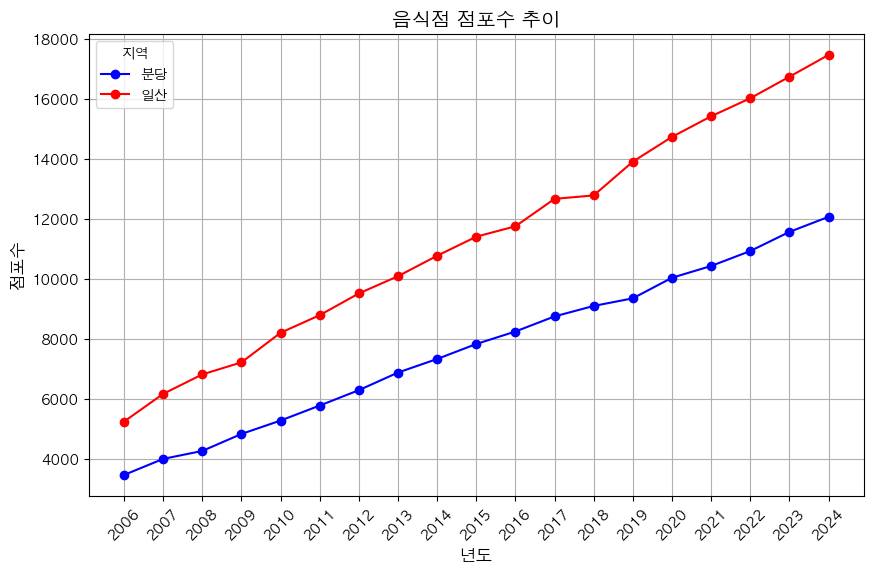

In [263]:
## 점포수
# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(count_df_bundang.loc[1:]['년도'], count_df_bundang.loc[1:]['년도별갯수'], marker='o', color='b', linestyle='-')
plt.plot(count_df_ilsan.loc[1:]['년도'], count_df_ilsan.loc[1:]['년도별갯수'], marker='o', color='r', linestyle='-')

# 그래프 제목과 축 라벨 설정
plt.title('음식점 점포수 추이', fontsize=14)
plt.xlabel('년도', fontsize=12)
plt.ylabel('점포수', fontsize=12)

# x축 tick을 2006부터 2024까지 설정
plt.xticks(count_df_bundang.loc[1:]['년도'], rotation=45)

# 격자 추가
plt.grid(True)

# 그래프에 레전드 추가
plt.legend(title='지역', labels=['분당', '일산'], loc='upper left')

# 그래프 출력
plt.show()

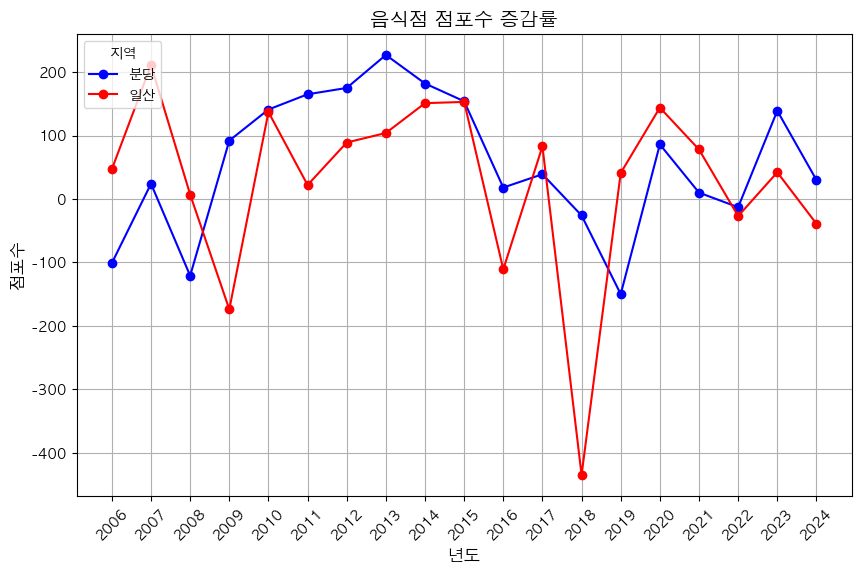

In [264]:
## 점포수
# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(count_df_bundang.loc[1:]['년도'], count_df_bundang.loc[1:]['증감률'], marker='o', color='b', linestyle='-')
plt.plot(count_df_ilsan.loc[1:]['년도'], count_df_ilsan.loc[1:]['증감률'], marker='o', color='r', linestyle='-')

# 그래프 제목과 축 라벨 설정
plt.title('음식점 점포수 증감률', fontsize=14)
plt.xlabel('년도', fontsize=12)
plt.ylabel('점포수', fontsize=12)

# x축 tick을 2006부터 2024까지 설정
plt.xticks(count_df_bundang.loc[1:]['년도'], rotation=45)

# 격자 추가
plt.grid(True)

# 그래프에 레전드 추가
plt.legend(title='지역', labels=['분당', '일산'], loc='upper left')

# 그래프 출력
plt.show()

# 학교

In [228]:
data = [x for x in dataset_list if '학교' in x]
print(data)

['dataset_life_infra_일산_학교.csv', 'dataset_life_infra_분당_학교.csv']


In [229]:
data_bundang = pd.read_csv(next((x for x in data if '분당' in x)))
data_ilsan = pd.read_csv(next((x for x in data if '일산' in x)))

In [230]:
data_bundang['설립년도'] = data_bundang['설립일자'].apply(lambda x: int(x.split("-")[0]))
data_bundang.loc[:, '설립년도'] = data_bundang['설립년도'].apply(lambda x: 2005 if int(x) < 2006 else x)
data_bundang_count = data_bundang.groupby('설립년도').size()

data_ilsan['설립년도'] = data_ilsan['설립일자'].apply(lambda x: int(x.split("-")[0]))
data_ilsan.loc[:, '설립년도'] = data_ilsan['설립년도'].apply(lambda x: 2005 if int(x) < 2006 else x)
data_ilsan_count = data_ilsan.groupby('설립년도').size()

In [ ]:
school_index = range(2005, 2025)

count_df_school = pd.DataFrame(index=school_index)
count_df_school['분당_설립년도_카운트'] = data_bundang_count
count_df_school['일산_설립년도_카운트'] = data_ilsan_count

# count_df_school = count_df_school.reset_index()
count_df_school.columns = ['년도', '분당_설립년도_카운트' ,'일산_설립년도_카운트']

# NaN 값을 0으로 채우기
count_df_school = count_df_school.fillna(0).astype(int)
display(count_df_school)

,년도,분당_설립년도_카운트,일산_설립년도_카운트
0,2005,68,72
1,2006,1,5
2,2007,0,1
3,2008,1,6
4,2009,8,0
5,2010,6,2
6,2011,1,5
7,2012,0,2
8,2013,1,0
9,2014,0,0


In [ ]:
count_df_school_cumulative = count_df_school.copy()
count_df_school_cumulative = count_df_school_cumulative.cumsum()
# count_df_school_cumulative = count_df_school_cumulative.reset_index()
count_df_school_cumulative.columns = ['년도', '분당_설립년도_카운트' ,'일산_설립년도_카운트']
display(count_df_school_cumulative)

,년도,분당_설립년도_카운트,일산_설립년도_카운트
0,2005,68,72
1,2006,69,77
2,2007,69,78
3,2008,70,84
4,2009,78,84
5,2010,84,86
6,2011,85,91
7,2012,85,93
8,2013,86,93
9,2014,86,93


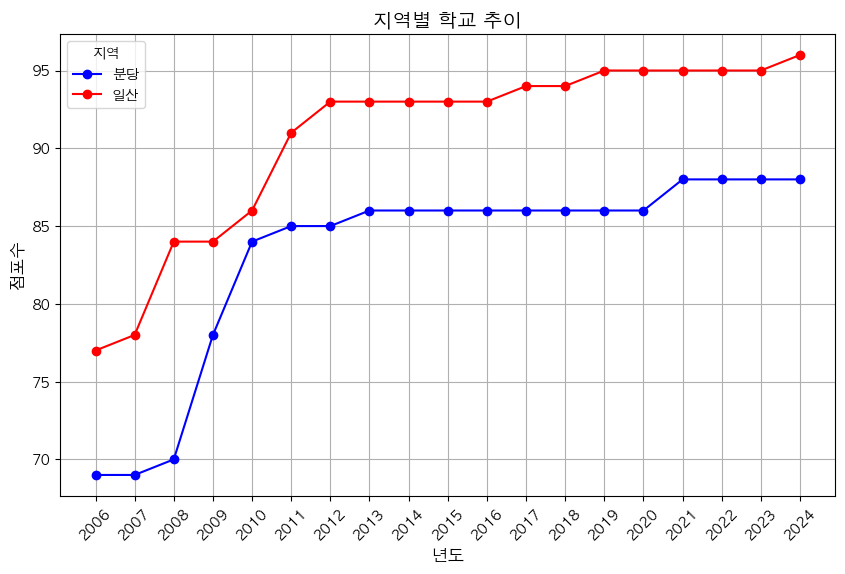

In [234]:
## 학교
# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(count_df_school_cumulative.loc[1:]['년도'], count_df_school_cumulative.loc[1:]['분당_설립년도_카운트'], marker='o', color='b', linestyle='-')
plt.plot(count_df_school_cumulative.loc[1:]['년도'], count_df_school_cumulative.loc[1:]['일산_설립년도_카운트'], marker='o', color='r', linestyle='-')

# 그래프 제목과 축 라벨 설정
plt.title('지역별 학교 추이', fontsize=14)
plt.xlabel('년도', fontsize=12)
plt.ylabel('점포수', fontsize=12)

# x축 tick을 2006부터 2024까지 설정
plt.xticks(count_df_school_cumulative.loc[1:]['년도'], rotation=45)

# 격자 추가
plt.grid(True)

# 그래프에 레전드 추가
plt.legend(title='지역', labels=['분당', '일산'], loc='upper left')

# 그래프 출력
plt.show()

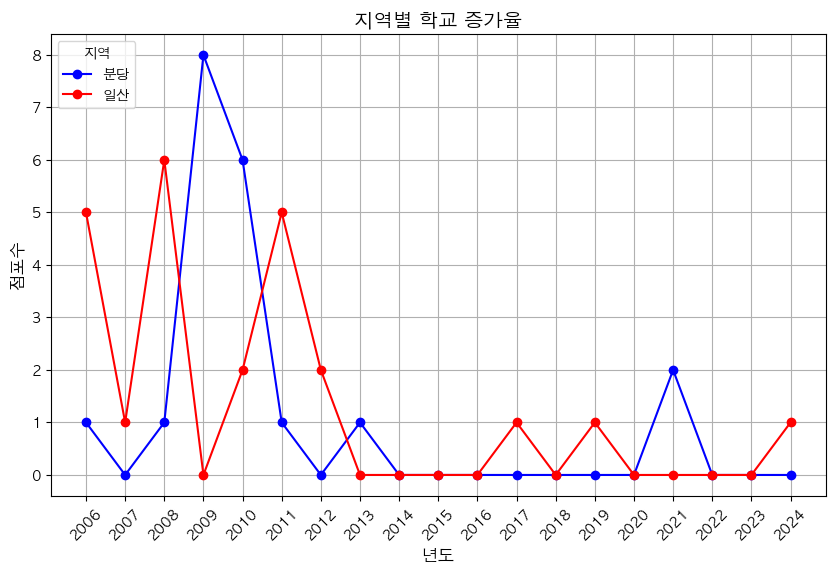

In [237]:
## 학교
# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(count_df_school.loc[1:]['년도'], count_df_school.loc[1:]['분당_설립년도_카운트'], marker='o', color='b', linestyle='-')
plt.plot(count_df_school.loc[1:]['년도'], count_df_school.loc[1:]['일산_설립년도_카운트'], marker='o', color='r', linestyle='-')

# 그래프 제목과 축 라벨 설정
plt.title('지역별 학교 증가율', fontsize=14)
plt.xlabel('년도', fontsize=12)
plt.ylabel('점포수', fontsize=12)

# x축 tick을 2006부터 2024까지 설정
plt.xticks(count_df_school.loc[1:]['년도'], rotation=45)

# 격자 추가
plt.grid(True)

# 그래프에 레전드 추가
plt.legend(title='지역', labels=['분당', '일산'], loc='upper left')

# 그래프 출력
plt.show()

# 병원 및 의원

In [128]:
data = [x for x in dataset_list if '병원' in x]
print(data)

['dataset_life_infra_일산_병원.csv', 'dataset_life_infra_분당_병원.csv']


In [129]:
data_bundang = pd.read_csv(next((x for x in data if '분당' in x)))
data_ilsan = pd.read_csv(next((x for x in data if '일산' in x)))

## 분당

In [164]:
# 인허가년도, 폐업연도 처리 부분
data_bundang['인허가년도'] = data_bundang['인허가일자'].apply(lambda x: int(x.split("-")[0]))
data_bundang['폐업연도'] = data_bundang['폐업일자'].apply(lambda x: int(x.split("-")[0]) if pd.notnull(x) else None)

# 필터링 및 데이터 처리
filter_1_bundang = data_bundang[data_bundang['폐업연도'].isna()]
filter_2_bundang = data_bundang[data_bundang['폐업연도'].notna() & (data_bundang['폐업연도'] > 2006)]

# filter_2_bundang에서 폐업연도를 Int64로 변환
filter_2_bundang.loc[:, '폐업연도'] = filter_2_bundang['폐업연도'].astype('Int64')

# 필터링된 데이터 결합
filtered_after_2006_bundang = pd.concat([filter_1_bundang, filter_2_bundang]).reset_index(drop=True)

# 데이터 복사
filtered_data_bundang = filtered_after_2006_bundang.copy()

# 인허가년도 변경 처리 (2006년 이전은 2006으로 설정)
filtered_data_bundang.loc[:, '인허가년도'] = filtered_data_bundang['인허가년도'].apply(lambda x: 2005 if x < 2006 else x)

In [ ]:
_, permit_bundang_count, closure_bundang_count, final_bundang_count = count_store(filtered_data_bundang)

# 증감률 시작일자 0으로 변경
change_rate_bundang = permit_bundang_count - closure_bundang_count
change_rate_bundang.iloc[0] = 0 


In [213]:
# Index 생성 (2006~2024)
index = range(2005, 2025)
# 신규 데이터프레임 생성

count_df_bundang = pd.DataFrame(index=index)
count_df_bundang['인허가갯수'] = permit_bundang_count
count_df_bundang['폐업갯수'] = closure_bundang_count
count_df_bundang = count_df_bundang.fillna(0).astype(int)

count_df_bundang['증감률'] = count_df_bundang['인허가갯수'] - count_df_bundang['폐업갯수']
count_df_bundang['년도별갯수'] = count_df_bundang['증감률'].cumsum()

count_df_bundang = count_df_bundang.reset_index()

count_df_bundang.columns = ['년도','인허가갯수', '폐업갯수', '증감률','년도별갯수']


In [214]:
count_df_bundang

,년도,인허가갯수,폐업갯수,증감률,년도별갯수
0,2005,19,0,19,19
1,2006,5,0,5,24
2,2007,1,0,1,25
3,2008,0,2,-2,23
4,2009,1,0,1,24
5,2010,2,1,1,25
6,2011,2,2,0,25
7,2012,3,1,2,27
8,2013,2,1,1,28
9,2014,0,2,-2,26


## 일산

In [192]:
# 인허가년도, 폐업연도 처리 부분
data_ilsan['인허가년도'] = data_ilsan['인허가일자'].apply(lambda x: int(x.split("-")[0]))
data_ilsan['폐업연도'] = data_ilsan['폐업일자'].apply(lambda x: int(x.split("-")[0]) if pd.notnull(x) else None)

# 필터링 및 데이터 처리
filter_1_ilsan = data_ilsan[data_ilsan['폐업연도'].isna()]
filter_2_ilsan = data_ilsan[data_ilsan['폐업연도'].notna() & (data_ilsan['폐업연도'] > 2006)]

# filter_2_ilsan에서 폐업연도를 Int64로 변환
filter_2_ilsan.loc[:, '폐업연도'] = filter_2_ilsan['폐업연도'].astype('Int64')

# 필터링된 데이터 결합
filtered_after_2006_ilsan = pd.concat([filter_1_ilsan, filter_2_ilsan]).reset_index(drop=True)

# 데이터 복사
filtered_data_ilsan = filtered_after_2006_ilsan.copy()

# 인허가년도 변경 처리 (2006년 이전은 2006으로 설정)
filtered_data_ilsan.loc[:, '인허가년도'] = filtered_data_ilsan['인허가년도'].apply(lambda x: 2005 if x < 2006 else x)

In [ ]:
_, permit_ilsan_count, closure_ilsan_count, final_ilsan_count = count_store(filtered_data_ilsan)

# # 증감률 시작일자 0으로 변경
# change_rate_ilsan = permit_ilsan_count - closure_ilsan_count
# change_rate_ilsan.iloc[0] = 0 

# # 데이터 프레임화
# count_df_ilsan = pd.DataFrame([_, closure_ilsan_count, change_rate_ilsan,final_ilsan_count]).T.reset_index()
# count_df_ilsan.columns = ['년도','인허가갯수', '폐업갯수', '증감률','년도별갯수']

In [215]:
# Index 생성 (2006~2024)
index = range(2005, 2025)
# 신규 데이터프레임 생성

count_df_ilsan = pd.DataFrame(index=index)
count_df_ilsan['인허가갯수'] = permit_ilsan_count
count_df_ilsan['폐업갯수'] = closure_ilsan_count
count_df_ilsan = count_df_ilsan.fillna(0).astype(int)

count_df_ilsan['증감률'] = count_df_ilsan['인허가갯수'] - count_df_ilsan['폐업갯수']
count_df_ilsan['년도별갯수'] = count_df_ilsan['증감률'].cumsum()

count_df_ilsan = count_df_ilsan.reset_index()

count_df_ilsan.columns = ['년도','인허가갯수', '폐업갯수', '증감률','년도별갯수']

In [216]:
count_df_ilsan

,년도,인허가갯수,폐업갯수,증감률,년도별갯수
0,2005,16,0,16,16
1,2006,4,0,4,20
2,2007,8,0,8,28
3,2008,6,3,3,31
4,2009,8,2,6,37
5,2010,2,2,0,37
6,2011,1,2,-1,36
7,2012,5,1,4,40
8,2013,4,2,2,42
9,2014,4,2,2,44


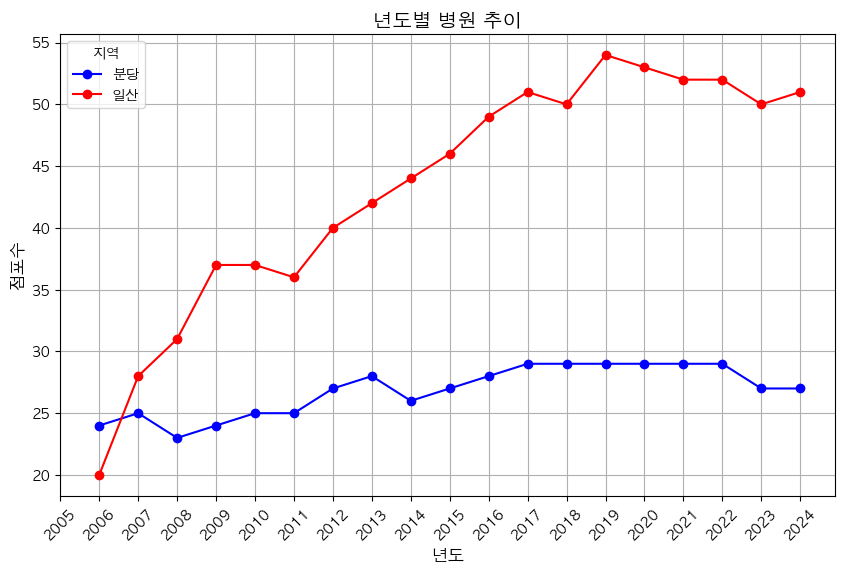

In [224]:
## 점포수
# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(count_df_bundang.loc[1:]['년도'], count_df_bundang.loc[1:]['년도별갯수'], marker='o', color='b', linestyle='-')
plt.plot(count_df_ilsan.loc[1:]['년도'], count_df_ilsan.loc[1:]['년도별갯수'], marker='o', color='r', linestyle='-')

# 그래프 제목과 축 라벨 설정
plt.title('년도별 병원 추이', fontsize=14)
plt.xlabel('년도', fontsize=12)
plt.ylabel('점포수', fontsize=12)

# x축 tick을 2006부터 2024까지 설정
plt.xticks(count_df_bundang['년도'], rotation=45)

# 격자 추가
plt.grid(True)

# 그래프에 레전드 추가
plt.legend(title='지역', labels=['분당', '일산'], loc='upper left')

# 그래프 출력
plt.show()

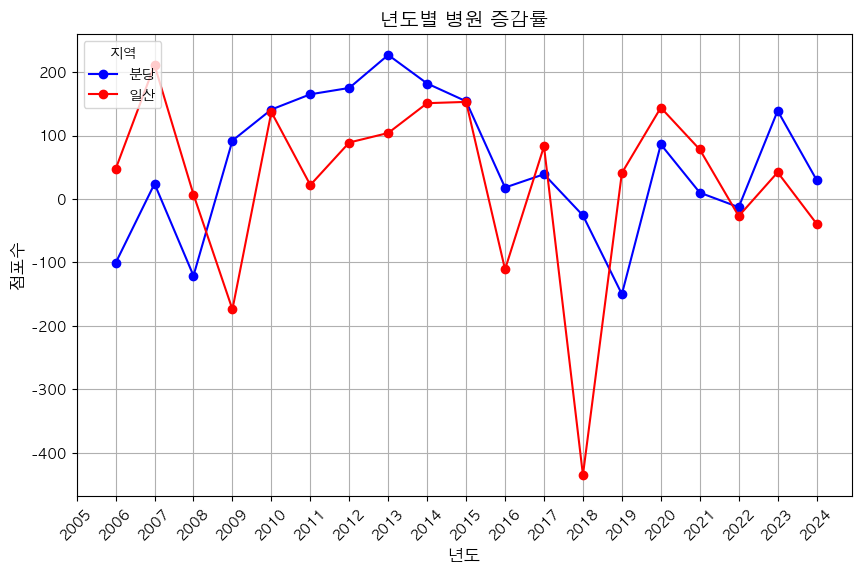

In [265]:
## 점포수
# 꺾은선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(count_df_bundang.loc[1:]['년도'], count_df_bundang.loc[1:]['증감률'], marker='o', color='b', linestyle='-')
plt.plot(count_df_ilsan.loc[1:]['년도'], count_df_ilsan.loc[1:]['증감률'], marker='o', color='r', linestyle='-')

# 그래프 제목과 축 라벨 설정
plt.title('년도별 병원 증감률', fontsize=14)
plt.xlabel('년도', fontsize=12)
plt.ylabel('점포수', fontsize=12)

# x축 tick을 2006부터 2024까지 설정
plt.xticks(count_df_bundang['년도'], rotation=45)

# 격자 추가
plt.grid(True)

# 그래프에 레전드 추가
plt.legend(title='지역', labels=['분당', '일산'], loc='upper left')

# 그래프 출력
plt.show()